In [59]:
from typing import Tuple, List

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

import openfermion as of
import qiskit
from qiskit.circuit.library import PauliEvolutionGate

import convert

In [30]:
l = 2 # Lattice length.
w = 3 # Lattice width.
fermi_ham = of.fermi_hubbard(l, w, 1.0, 1.0, periodic=False, spinless=True)
ham = of.transforms.jordan_wigner(fermi_ham)
nq = of.count_qubits(ham)

In [32]:
# State prep circuit:
# For now use a Neel state.
state_prep_ckt = qiskit.QuantumCircuit(nq)
for i in range(nq):
    if i % 2 == 0:
        state_prep_ckt.x(i)

## Exact ground state energy

## _S_ and _H_ matrices

In [37]:
def trotter_circuit(ham: of.QubitOperator, dt: float, steps: int) -> qiskit.QuantumCircuit:
    """Get a circuit for time evolution with the Hamiltonian ham
    using a time step of length dt."""

    assert dt > 0.0
    assert steps > 0

    psum_ham = of.transforms.qubit_operator_to_pauli_sum(ham)
    qiskit_ham = convert.cirq_pauli_sum_to_qiskit_pauli_op(psum_ham)

    circuit = qiskit.QuantumCircuit(qiskit_ham.num_qubits)
    gate = PauliEvolutionGate(qiskit_ham)
    for _ in range(steps):
        circuit.append(gate, range(qiskit_ham.num_qubits))
    return circuit

In [56]:
def subspace_matrices(
    ham: of.QubitOperator, state_prep_circuit: qiskit.QuantumCircuit, tau: float, steps: int, d: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Get the S and H matrices for the subsapce generated by
    realt time evolution for time tau, up to subspace dimension d.
    The subspace is generated by the unitary U = exp(-i H tau),
    wich we approximate by N steps of a first-order Trotter
    approximation.
    
    Arguments:
    ham - Hamiltonian of the system.
    state_prep_circuit - Circuit to prepare the reference state.
    tau - time for the evolution operator (not the trotter step, the time for U.)
    steps - Number of steps to make U.
    d - Subpsace dimension
    
    Returns:
    H - Hamiltonian projected into subspace.
    S - overlap matrix of subspace."""

    dt = tau / float(steps)
    trotter_ckt = trotter_circuit(ham, dt, steps)

    # Store the reference state to compute overlaps.
    reference_state = qiskit.quantum_info.Statevector(state_prep_circuit)

    # TODO Should I be using the Qiskit Operator class?
    ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham)
    ham_qiskit = convert.cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
    ham_matrix = ham_qiskit.to_matrix()

    h = np.zeros((d, d), dtype=complex)
    s = np.zeros((d, d), dtype=complex)
    for k in range(d):
        # TODO Use Ashley Monatanaro's method?
        # Compute the state vector for U^d |ref>.
        total_ckt = state_prep_circuit.copy()
        for _ in range(k):
            total_ckt = total_ckt.compose(trotter_ckt)
        evolved_state = qiskit.quantum_info.Statevector(total_ckt)
        overlap = np.vdot(reference_state.data, evolved_state.data)
        mat_elem = np.vdot(reference_state.data, ham_matrix @ evolved_state.data)
        # Assign all elements of S and H for which |i-j| = k.
        for i in range(d):
            for j in range(d):
                if i - j == k:
                    s[i, j] = overlap
                    h[i, j] = mat_elem
                if j - i == k:
                    s[i, j] = overlap.conjugate()
                    h[i, j] = mat_elem.conjugate()
    assert la.ishermitian(h)
    assert la.ishermitian(s)
    return h, s

In [63]:
def energy_vs_d(h, s) -> Tuple[List[int], List[float]]:
    """Get energy vs. subspace dimension.
    If H and S are of dimension D, we can get the energy estimate
    for d < D by taking the upper left d x d blocks of H and S."""

    assert h.shape == s.shape
    assert h.shape[0] == h.shape[1]
    ds: List[int] = []
    energies: List[float] = []
    for d in range(1, h.shape[0]):
        ds.append(d)
        lam, v = la.eig(h[:d, :d], s[:d, :d])
        energies.append(np.min(lam))
    return ds, energies

In [62]:
h, s = subspace_matrices(ham, state_prep_ckt, 1e-3, 2, 100)

In [64]:
ds, energies = energy_vs_d(h, s)

/opt/homebrew/Caskroom/miniconda/base/envs/compare/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniconda/base/envs/compare/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


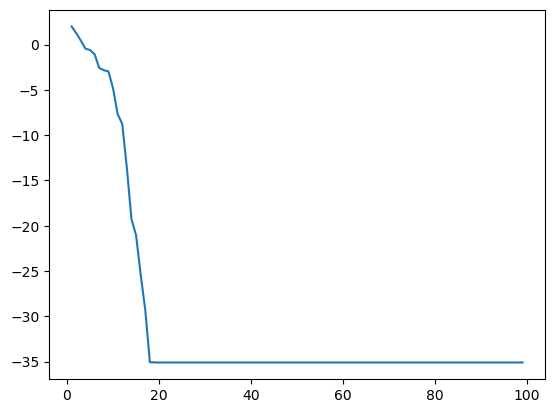

In [65]:
fig, ax = plt.subplots()
ax.plot(ds, energies)